In [7]:
from tasks.feature_db import ImageObservationDB

image_obs_dir = "../data/marked_obs"
caption_dir = "../data/MP3D/GPT-4o_caption.json"
navigable_dir = "../data/MP3D/navigable.json"
scan = "1LXtFkjw3qL"
viewpoint_id = "0b302846f0994ec9851862b1d317d7f2"

obs = ImageObservationDB(image_obs_dir, caption_dir, None, None)

ob = obs.get_image_observation(scan, viewpoint_id, -48)

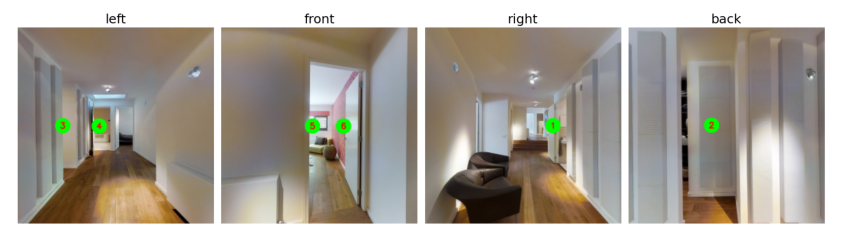

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.imshow(ob['img_obs']['egocentric'])
plt.axis('off')
plt.show()

In [9]:
ob['action_options']

{'Left': {'3': 'Hallway with wooden flooring and wall lighting; leads toward a distant room with a visible doorway.',
  '4': 'Hallway with wooden flooring and a darker room visible; leads toward a bedroom or private space.'},
 'Front': {'5': 'Room with pink wallpaper and a sofa; leads toward a cozy living or lounge area.',
  '6': 'Room with pink wallpaper and a visible bed; leads toward a bedroom or resting area.'},
 'Right': {'1': 'Hallway with wooden flooring and seating; leads toward a brighter area with stairs visible in the distance.'},
 'Back': {'2': 'Closet or storage area with white panel doors; leads to a compact storage or utility space.'}}

In [14]:
import re
text = "Answer: 2"
regex = (r"(?<=Answer:\s)(-?\d+(\.\d+)?)")

action_match = re.search(regex, text)

actions = [action_match.group().strip()]

print(actions)


['2']


In [18]:
target_caption = ob['caption'][actions[0]]
# Extract viewpoint ID
tool_input = ob['id_viewpoint'][actions[0]]
target = [tool_input.strip(" ").strip('"').strip("'")]

print(target)

import json
with open(navigable_dir, 'r') as f:
    navigable = json.load(f)[scan]
distance = navigable[viewpoint_id][target[0]]['distance']

distance

['e345211511824219a62f1b8d639c477e']


1.3878421783447266

In [ ]:
def normalize_angle(angle):
    while angle > 180:
        angle -= 360
    while angle <= -180:
        angle += 360
    return angle

def angle_to_left_right(angle):
    return f"left {-angle:.2f}" if angle < 0 else f"right {angle:.2f}"


In [10]:
import json
with open(navigable_dir, 'r') as f:
    navigable = json.load(f)[scan]
    
navigable[viewpoint_id][tool_input]


{'heading': 1.4140784750368933,
 'elevation': 0.0020751489770660394,
 'ang_dis': 0.15673158999678558,
 'distance': 1.3878421783447266}

In [2]:
ob

{'img_obs': {'left': <PIL.Image.Image image mode=RGB size=256x256>,
  'front': <PIL.Image.Image image mode=RGB size=256x256>,
  'right': <PIL.Image.Image image mode=RGB size=256x256>,
  'back': <PIL.Image.Image image mode=RGB size=256x256>,
  'egocentric': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1600x400>},
 'caption': {'1': 'Hallway with wooden flooring and seating; leads toward a brighter area with stairs visible in the distance.',
  '2': 'Closet or storage area with white panel doors; leads to a compact storage or utility space.',
  '3': 'Hallway with wooden flooring and wall lighting; leads toward a distant room with a visible doorway.',
  '4': 'Hallway with wooden flooring and a darker room visible; leads toward a bedroom or private space.',
  '5': 'Room with pink wallpaper and a sofa; leads toward a cozy living or lounge area.',
  '6': 'Room with pink wallpaper and a visible bed; leads toward a bedroom or resting area.'},
 'summary': None,
 'map': None,
 'id_viewpoi

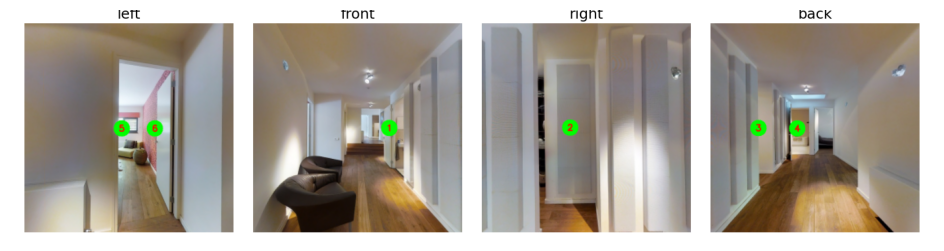

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.imshow(ob['img_obs']['egocentric'])
plt.axis('off')
plt.show()

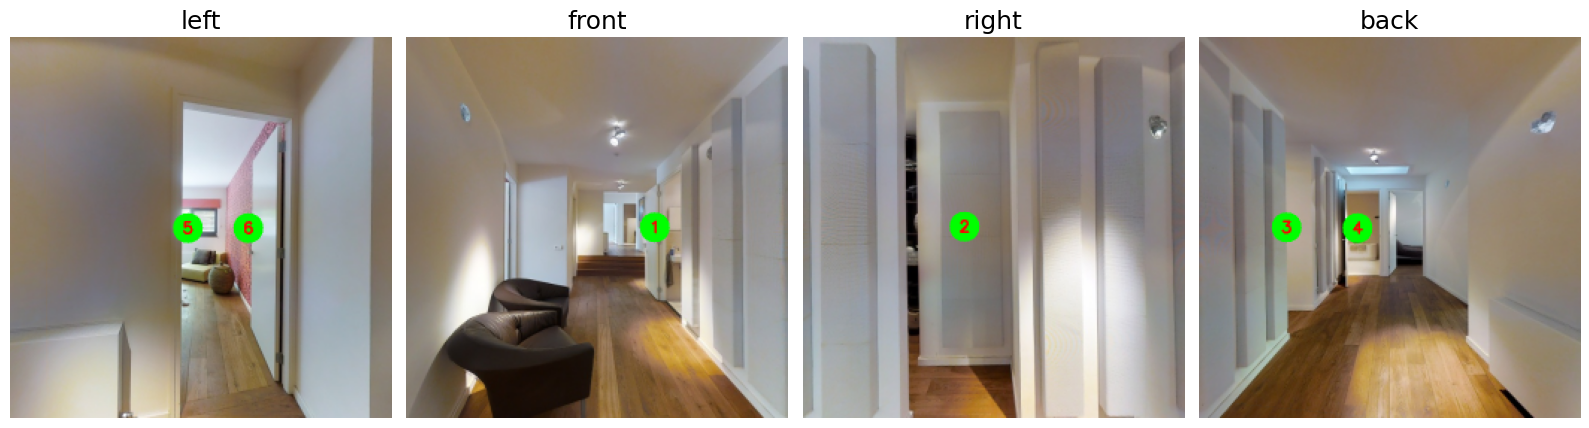

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

def display_four_images(img_obs):
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 4, figsize=(16, 8)) # figsize (width, height) in inches

    # Iterate through the images and display them
    for i, (direction, img) in enumerate(img_obs.items()):
        if img is not None and isinstance(img, Image.Image):
            axes[i].imshow(img)
            axes[i].set_title(direction, fontsize=18) # Get title or default
            axes[i].axis('off') # Hide axes ticks and labels for cleaner display

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show()

# Call the function with the 'img_obs' part of your dictionary
display_four_images(ob['img_obs'])

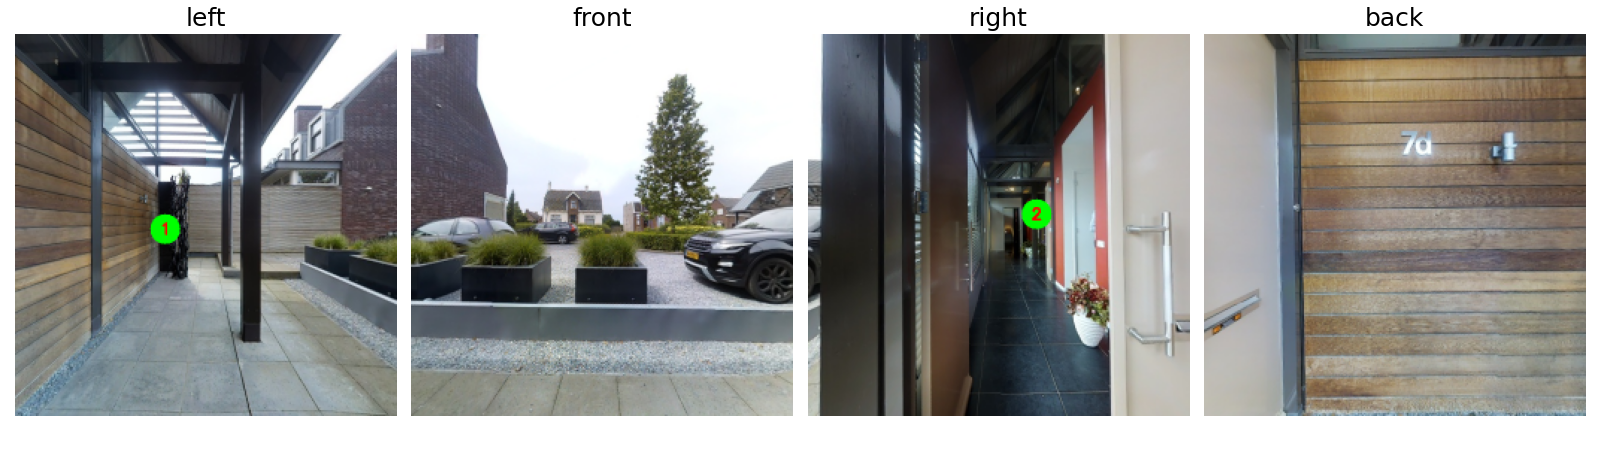

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import io

def display_four_images_with_heading(img_obs, heading_deg=0):
    # Normalize heading to be within 0 to 359 degrees
    normalized_heading = heading_deg % 360
    if normalized_heading < 0:
        normalized_heading += 360

    if (normalized_heading >= 315 and normalized_heading < 360) or \
       (normalized_heading >= 0 and normalized_heading < 45):
        current_front_key = 'front'
        global_front_deg = 0
    elif normalized_heading >= 45 and normalized_heading < 135:
        current_front_key = 'right'
        global_front_deg = 90
    elif normalized_heading >= 135 and normalized_heading < 225:
        current_front_key = 'back'
        global_front_deg = 180
    elif normalized_heading >= 225 and normalized_heading < 315:
        current_front_key = 'left'
        global_front_deg = 270
    else:
        current_front_key = 'front'
        global_front_deg = 0
        print(f"Warning: Could not determine current front based on heading {heading_deg}. Defaulting to 'front'.")

    global_order_keys = ['left', 'front', 'right', 'back']
    idx_current_front = global_order_keys.index(current_front_key)

    display_keys = [
        global_order_keys[(idx_current_front - 1 + 4) % 4], # Agent's Left
        global_order_keys[idx_current_front],               # Agent's Front
        global_order_keys[(idx_current_front + 1) % 4],     # Agent's Right
        global_order_keys[(idx_current_front + 2) % 4]      # Agent's Back
    ]

    TITLE_FONT_SIZE = 18
    fig, axes = plt.subplots(1, 4, figsize=(16, 4.5))

    for i, key_to_display in enumerate(display_keys):
        img_to_show = img_obs.get(key_to_display)

        if img_to_show is not None and isinstance(img_to_show, Image.Image):
            axes[i].imshow(img_to_show)
            axes[i].set_title(global_order_keys[i], fontsize=TITLE_FONT_SIZE)
            axes[i].axis('off')
        else:
            print(f"Warning: Image for global '{key_to_display}' is missing or not a PIL Image object.")
            axes[i].set_title(f'No {global_order_keys[i]} Image', fontsize=TITLE_FONT_SIZE)
            axes[i].axis('off')

    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close(fig)  # Close the figure to free memory
    buf.seek(0)

    # Convert buffer to PIL Image
    img_result = Image.open(buf)
    return img_result

display_four_images_with_heading(ob['img_obs'], 46)


In [2]:
d = {
    "a": {"x": 9, "y": 4},
    "b": {"x": 9, "y": 4},
    "c": {"x": 9, "y": 4}
}

list(d)[1]

'b'